In [75]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-colorblind')

In [2]:

sat_1987_1998 = pd.read_excel('data/SAT_1987_1998.xls', skiprows=range(11))
sat_2017_2018 = pd.read_excel('data/SAT_2017_2018.xls', skiprows=range(5))

#2005-2015
old_2006_2009 = pd.read_excel('data/2006_2009.xls', skiprows=range(3)) #<-- 2005,2007,2008,2009
load_2006 = pd.read_excel('data/2006.xls', skiprows = range(6)) #<-- 2006
sat_1995_2015 = pd.read_excel('data/SAT_1995_2015.xls', skiprows=range(3)) #<-- 2010, 2013, 2014
load_2011_2012 = pd.read_excel('data/2010-2012.xls', skiprows=range(5)) #<-- 2011, 2012
load_2015 = pd.read_excel('data/2015.xls', skiprows=range(5)) #<-- 2015


#Remove unwanted rows and columns
sat_2017 = sat_2017_2018.iloc[:-3, :8]
sat_2018 = sat_2017_2018.iloc[:-3, 8:]

### Old SAT format: 2400 score. Lasted from 2005-2015

In [3]:
#Filtering, splitting functions

#Get the clean list of states from the DF.
def clean_states(df:pd.DataFrame) -> list:
    states_list = []
    for i in df.iloc[:, 0]:
        states_list.append(i.split('.')[0])
        
    return states_list

#Cleaning up data and split the DF into respective years if applicable
def clean_multi_dataset(df, renamed_col = ['State', 'Reading', 'Math', 'Writing']):
    for i in range(1, len(df.columns) - 1, 3):
        data_year = df.iloc[:,i:i+3]

        data_year.insert(0, 'States', clean_states(df))
        data_year.columns = renamed_col
        data_year['SAT Total Score'] = data_year.apply(lambda row: row.Reading + row.Math + row.Writing, axis=1)

        yield data_year
    
#For grabbing a single year out of the dataset:
def clean_dataset(df, start, end, renamed_col = ['State', 'Reading', 'Math', 'Writing']):
    data_year = df.iloc[:, start:end]

    data_year.insert(0, 'States', clean_states(df))
    data_year.columns = renamed_col
    data_year['SAT Total Score'] = data_year.apply(lambda row: row.Reading + row.Math + row.Writing, axis=1)

    return data_year

In [4]:
#Clean table of NaN rows and columns and nonuseful data.
def remove_nan(df):
    return df[pd.notnull(df.iloc[:,1])]

#Ready for splitting and filtering:

#For 2006
data_2006 = remove_nan(load_2006)

#For 2005, 2007, 2008, 2009
old_2006_2009 = remove_nan(old_2006_2009).drop(columns=[2,3,4,5,18,19])

#For 2010, 2013, 2014
sat_1995_2015 = remove_nan(sat_1995_2015).drop(columns=[2,3,4,5,6,7,8,18,19])

#For 2011, 2012
load_2011_2012 = remove_nan(load_2011_2012)

#For 2015
load_2015 = remove_nan(load_2015)

In [70]:


#Relevant tables for 2005-2010:
cleaned_2005_2009 = clean_multi_dataset(old_2006_2009) #<-- 2005, 2007, 2008, 2009
cleaned_10_13_14 = clean_multi_dataset(sat_1995_2015) #<-- 2010, 2013, 2014
cleaned_11_12 = clean_multi_dataset(load_2011_2012) #<-- 2011, 2012

# Data for 2005-2010:
sat_2005 = next(cleaned_2005_2009)
sat_2006 = clean_dataset(data_2006, 12, 15)
sat_2007 = next(cleaned_2005_2009)
sat_2008 = next(cleaned_2005_2009)
sat_2009 = next(cleaned_2005_2009)
# sat_2010 = next(cleaned_10_13_14)

# #Data for 2011-2015:
sat_2010 = next(cleaned_10_13_14)
sat_2011 = next(cleaned_11_12)
sat_2012 = next(cleaned_11_12)
sat_2013 = next(cleaned_10_13_14)
sat_2014 = next(cleaned_10_13_14)
sat_2015 = clean_dataset(load_2015, 14, 17)

### 2005-2010 SAT Total Score for each State: 


In [6]:
to_merge = [sat_2005[['State', 'SAT Total Score']], sat_2006[['State', 'SAT Total Score']], sat_2007[['State', 'SAT Total Score']], 
            sat_2008[['State', 'SAT Total Score']], sat_2009[['State', 'SAT Total Score']]]



In [76]:
df = reduce(lambda x, y: pd.merge(x,y, on='State', how='inner'), to_merge)
df.columns = ['States', '2005 SAT Scores', '2006 SAT Scores', '2007 SAT Scores', '2008 SAT Scores', '2009 SAT Scores']

Text(0.5, 51.0, 'SAT Score')

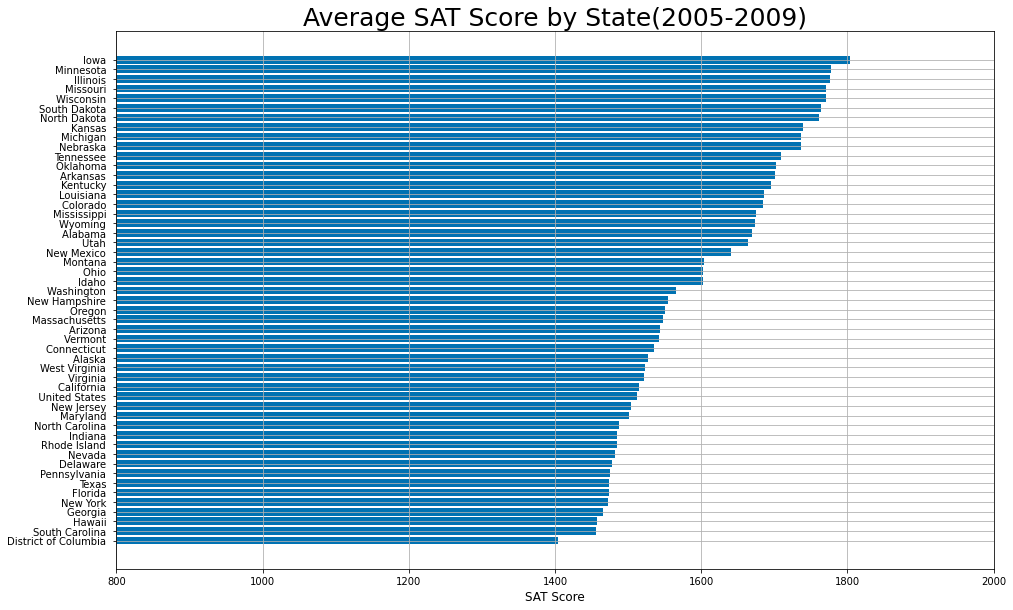

In [69]:
df['Average Over 5 Years'] = df.drop('States', axis=1).apply(lambda x: x.mean(), axis=1)
df.sort_values(['Average Over 5 Years'], axis=0, ascending=True, inplace=True)


#Plotting
x = df['States']


fig, ax = plt.subplots(figsize=(14,8))
ax.barh(x, df['Average Over 5 Years'])

ax.grid(linestyle='-')
plt.tight_layout()
ax.set_xlim(800, 2000)
ax.set_title('Average SAT Score by State(2005-2009)', fontsize=25)
plt.xlabel('SAT Score', fontsize=12)

### 2011-2015 SAT Total Score for each State: 

Text(0.5, 51.0, 'SAT Score')

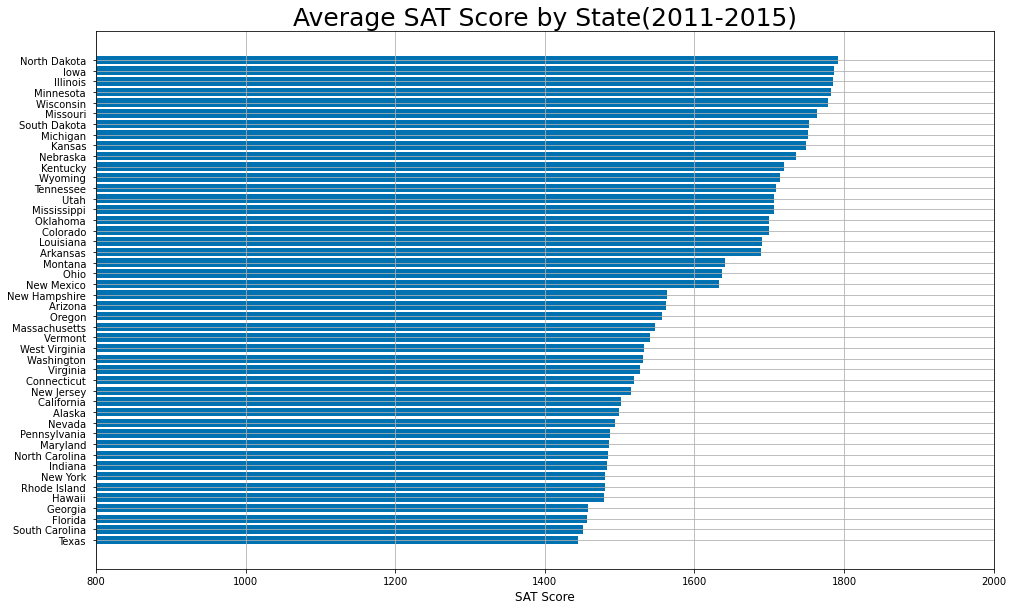

In [80]:
merge_ = [sat_2011[['State', 'SAT Total Score']], sat_2012[['State', 'SAT Total Score']], sat_2013[['State', 'SAT Total Score']], 
            sat_2014[['State', 'SAT Total Score']], sat_2015[['State', 'SAT Total Score']]]

df2 = reduce(lambda x, y: pd.merge(x,y, on='State', how='inner'), merge_)
df2.columns = ['States', '2011 SAT Scores', '2012 SAT Scores', '2013 SAT Scores', '2014 SAT Scores', '2015 SAT Scores']

df2['Average Over 5 Years'] = df2.drop('States', axis=1).apply(lambda x: x.mean(), axis=1)
df2.sort_values(['Average Over 5 Years'], axis=0, ascending=True, inplace=True)


#Plotting
x = df2['States']


fig, ax = plt.subplots(figsize=(14,8))
ax.barh(x, df2['Average Over 5 Years'])

ax.grid(linestyle='-')
plt.tight_layout()
ax.set_xlim(800, 2000)
ax.set_title('Average SAT Score by State(2011-2015)', fontsize=25)
plt.xlabel('SAT Score', fontsize=12)

In [79]:
df2

,States,2011 SAT Scores,2012 SAT Scores,2013 SAT Scores,2014 SAT Scores,2015 SAT Scores,Average Over 5 Years
9,Illinois,1715.0,1789.0,1802.0,1802.0,1819.0,1404.8
40,Vermont,1517.0,1538.0,1554.0,1554.0,1541.0,1456.8
12,Kansas,1727.0,1752.0,1753.0,1748.0,1769.0,1457.4
11,Iowa,1783.0,1818.0,1794.0,1755.0,1785.0,1465.6
32,Oregon,1570.0,1578.0,1544.0,1546.0,1545.0,1472.6
43,West Virginia,1559.0,1541.0,1522.0,1501.0,1538.0,1473.4
10,Indiana,1487.0,1508.0,1474.0,1473.0,1472.0,1473.4
38,Texas,1488.0,1496.0,1432.0,1410.0,1393.0,1475.6
8,Hawaii,1481.0,1506.0,1460.0,1472.0,1478.0,1478.2
28,North Carolina,1469.0,1507.0,1483.0,1478.0,1485.0,1482.0
